In [1]:
from nerfstudio.field_components.mlp import MLP
from torchview import draw_graph
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
test_mlp = MLP(in_dim=16, num_layers=3, layer_width=32)

Building MLP with 3 layers

Input dimension: 16

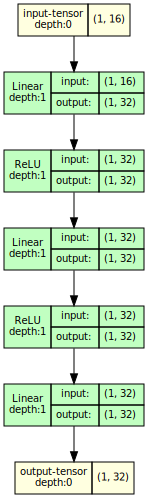

In [3]:
graph = draw_graph(test_mlp, (torch.randn(1, 16), ))
graph.visual_graph

In [4]:
class CustomMLP(nn.Module):
    def __init__(
        self, 
        in_dim,
        num_layers,
        layer_width,
        out_dim=None,
        activation=nn.ReLU(),
        out_activation=None,):
        
        
        super(CustomMLP, self).__init__()
        self.in_dim = in_dim
        self.num_layers = num_layers
        self.layer_width = layer_width
        self.out_dim = out_dim
        self.activation = activation
        self.out_activation = out_activation
        self.layers = nn.ModuleList()
        
        
        
    def build_nn_modules(self):
        # Add the first layer which directly takes the input
        self.layers.append(nn.Linear(self.in_dim, self.layer_width))
        
        # Add remaining layers, which take concatenated input
        for _ in range(1, self.num_layers):
            self.layers.append(nn.Linear(self.in_dim + self.layer_width, self.layer_width))
        
        # Output layer
        self.output_layer = nn.Linear(self.in_dim + self.layer_width, self.out_dim)

    def pytorch_fwd(self, in_tensor):
        x = in_tensor
        original_input = x
        
        # Initialize 'x' for concatenation
        x = self.layers[0](x)  # Process the first layer separately
        if self.activation is not None:
            x = self.activation(x)
        
        # Process remaining layers
        for i, layer in enumerate(self.layers[1:]):
            x = torch.cat((original_input, x), dim=1)  # Concatenate original input and output from the previous layer
            if self.activation is not None and i < len(self.layers) - 1:
                x = self.activation(layer(x))
        
        # Final output layer
        output = self.output_layer(torch.cat((original_input, x), dim=1))
        if self.out_activation is not None:
            output = self.out_activation(output)
        return output
    
    def forward(self,in_tensor):
        return self.pytorch_fwd(in_tensor)

In [5]:
in_dim = 10
layer_width = 20
out_dim = 5
num_layers = 4 

model = CustomMLP(in_dim, num_layers, layer_width, out_dim, )
model.build_nn_modules()


In [6]:
# Example input tensor
input_tensor = torch.randn(1, in_dim)

# Forward pass
output_tensor = model(input_tensor)
print(output_tensor)

tensor([[ 0.1559, -0.3051,  0.3220, -0.1249,  0.5538]],
       grad_fn=<AddmmBackward0>)


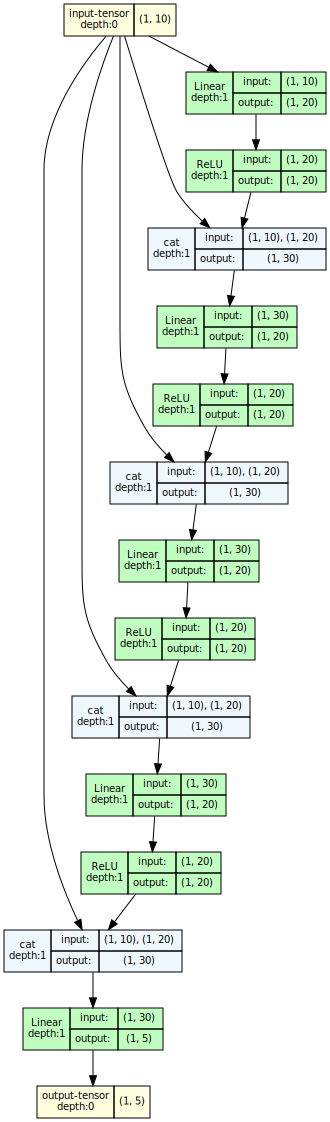

In [7]:
graph = draw_graph(model, (torch.randn(1, in_dim)), expand_nested=True)
graph.resize_graph(1.5)
graph.visual_graph